# Tomato Disease Detection & Classification (Hybrid Approach)


**Methodology:**
1.  **Detection (Segmentation):** `a-channel` thresholding logic
2.  **Categorization (ML Classification):** Extracts statistical features (texture, shape, color) from the isolated lesion and uses a Random Forest Classifier to distinguish between *Bacterial Spot*, *Early Blight*, and *Late Blight*.

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from joblib import Parallel, delayed
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Feature Extraction

The `extract_features` function computes a 27-dimensional feature vector for each isolated lesion:
*   **Shape:** Area, Perimeter, Circularity.
*   **Color:** Mean Color (BGR), HSV Histograms.
*   **Texture:** GLCM properties (Contrast, Homogeneity, etc.) on the quantized gray-scale ROI.


In [ ]:
def extract_features(img, mask):
    """
    Extracts Shape, Color, Histogram, and Texture features from the masked lesion.
    Returns: Feature vector of length 27.
    """
    if img is None or mask is None or cv2.countNonZero(mask) == 0:
        return np.zeros(27)

    # 1. Shape Features
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return np.zeros(27)
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    circularity = 0 if perimeter == 0 else (4 * np.pi * area) / (perimeter ** 2)

    # 2. Mean Color
    mean_color = cv2.mean(img, mask=mask)[:3]

    # 3. Color Histograms (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Hue (8 bins)
    hist_hue = cv2.calcHist([hsv], [0], mask, [8], [0, 180])
    cv2.normalize(hist_hue, hist_hue, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # Saturation (8 bins)
    hist_sat = cv2.calcHist([hsv], [1], mask, [8], [0, 256])
    cv2.normalize(hist_sat, hist_sat, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    hist_features = np.concatenate([hist_hue.flatten(), hist_sat.flatten()])

    # 4. Rotation-Invariant GLCM Texture
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x, y, w, h = cv2.boundingRect(largest_contour)
    roi = gray[y:y+h, x:x+w]

    if roi.size == 0:
        texture_features = np.zeros(5)
    else:
        # Quantize to 32 levels
        roi_quantized = (roi // 8).astype(np.uint8)
        # GLCM at 0, 45, 90, 135 degrees
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(roi_quantized, distances=[1], angles=angles, levels=32, symmetric=True, normed=True)

        # Average features over all angles
        contrast = np.mean(graycoprops(glcm, 'contrast'))
        dissimilarity = np.mean(graycoprops(glcm, 'dissimilarity'))
        homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
        energy = np.mean(graycoprops(glcm, 'energy'))
        correlation = np.mean(graycoprops(glcm, 'correlation'))

        texture_features = np.array([contrast, dissimilarity, homogeneity, energy, correlation])

    return np.concatenate([np.array([area, perimeter, circularity]), np.array(mean_color), hist_features, texture_features])

## 3. Segmentation Logic

The `get_disease_mask` function isolates the disease lesion from the leaf background:
1.  **Preprocessing:** Resizes image to standard width (800px) and applies Gaussian Blur.
2.  **Color Thresholding:** Converts to LAB color space and applies Otsu's thresholding on the **'a' channel** (green-red component), which effectively highlights reddish/brown disease spots against green leaves.
3.  **Refinement:** Uses morphological operations to clean the mask.


In [ ]:
def get_disease_mask(image_path):
    """
    Reads an image, resizes it, and applies LAB segmentation (Otsu) to isolate the lesion.
    Returns: Resized Image, Binary Mask
    """
    img = cv2.imread(image_path)
    if img is None: return None, None

    # Resize to width 800
    h, w = img.shape[:2]
    aspect_ratio = 800 / w
    img = cv2.resize(img, (800, int(h * aspect_ratio)))

    # Denoise
    img_clean = cv2.GaussianBlur(img, (5, 5), 0)

    # LAB Color Space -> 'a' channel
    lab = cv2.cvtColor(img_clean, cv2.COLOR_BGR2LAB)
    _, a, _ = cv2.split(lab)

    # Threshold 'a' channel using Otsu's method
    _, mask = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological Refinement
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return img, mask

## 4. Visualization Utility

Helper function to visualize the intermediate steps of the segmentation pipeline (Original -> 'a' Channel -> Mask -> Result).


In [ ]:
def visualize_segmentation_steps(img_paths):
    """
    Visualizes the segmentation pipeline steps for a list of images.
    """
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None: continue

        # Resize
        h, w = img.shape[:2]
        aspect_ratio = 800 / w
        img = cv2.resize(img, (800, int(h * aspect_ratio)))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Steps
        img_clean = cv2.GaussianBlur(img, (5, 5), 0)
        lab = cv2.cvtColor(img_clean, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Otsu's Thresholding on 'a' channel
        _, mask_raw = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask_close = cv2.morphologyEx(mask_raw, cv2.MORPH_CLOSE, kernel)
        mask_final = cv2.morphologyEx(mask_close, cv2.MORPH_OPEN, kernel)
        segmented = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_final)

        # Plot
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        titles = ["Original", "'a' Channel", "Otsu Threshold", "Refined Mask", "Segmented Lesion"]
        images = [img_rgb, a, mask_raw, mask_final, segmented]
        cmaps = [None, 'gray', 'gray', 'gray', None]

        for ax, image, title, cmap in zip(axes, images, titles, cmaps):
            ax.imshow(image, cmap=cmap)
            ax.set_title(title)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

## 5. Main Execution Pipeline

1.  **Visualization:** Displays segmentation results for a few sample images.
2.  **Data Processing:** Iterates through dataset folders, extracts features in parallel from all images.
3.  **Model Training:** Trains a **Random Forest** (with GridSearch) and an **SVM** classifier.
4.  **Evaluation:** Compares both models on a test set and plots the confusion matrix of the best performer.


Selecting and visualizing samples from each class...


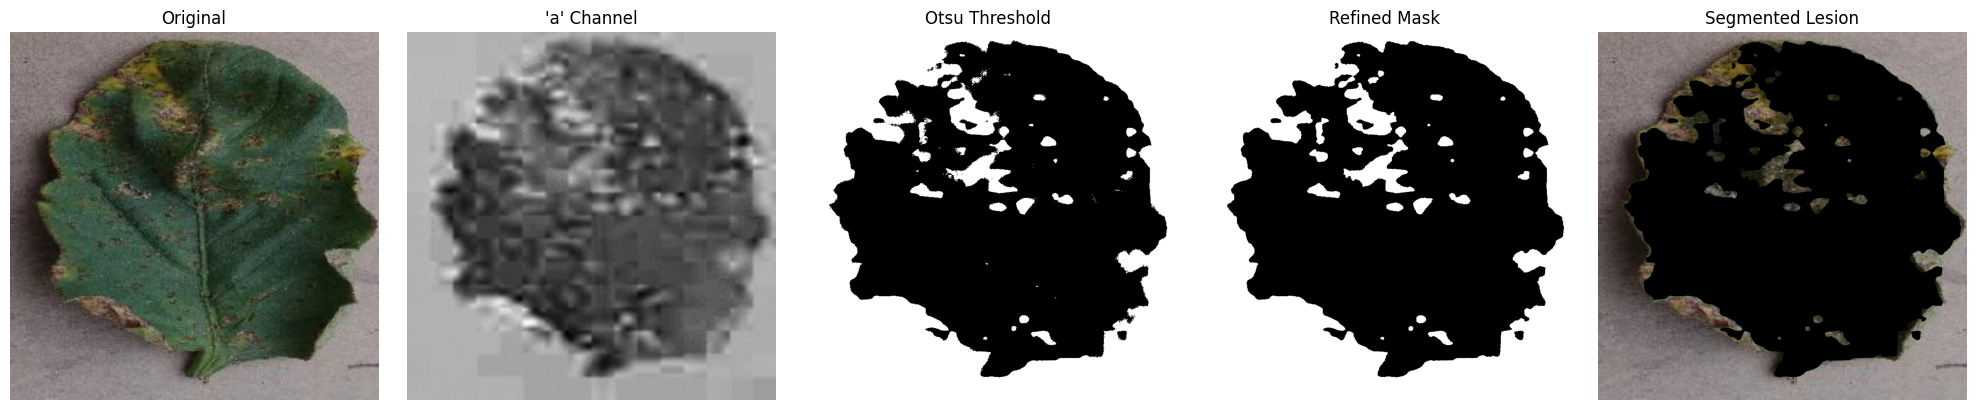

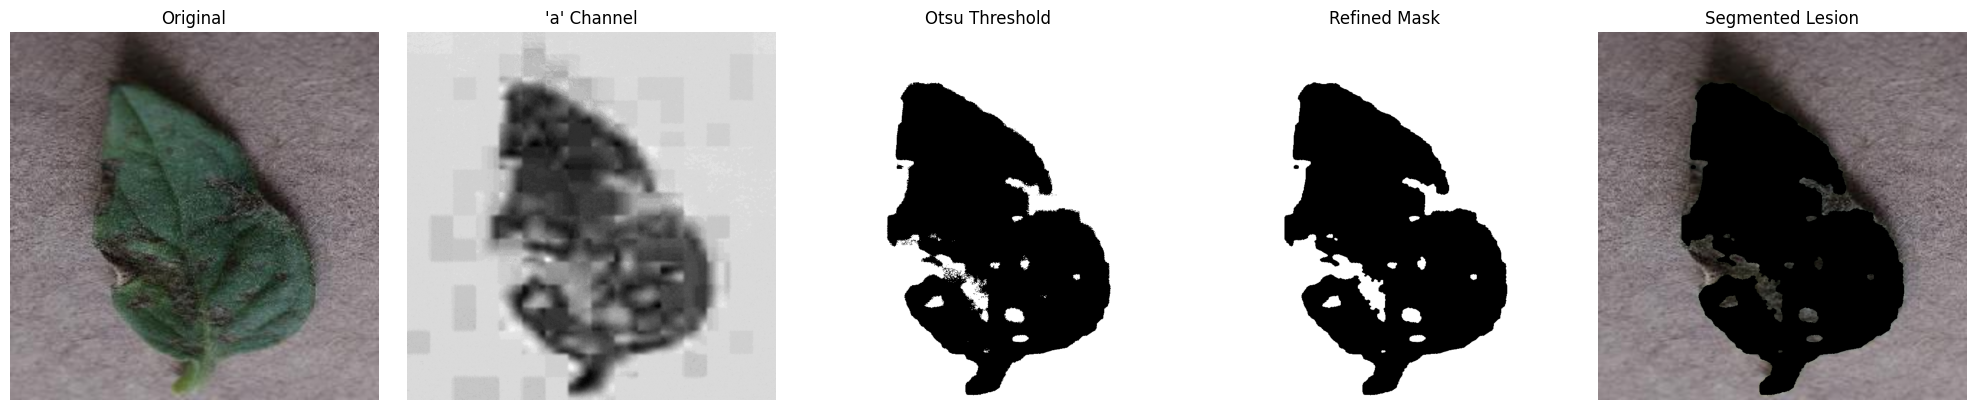

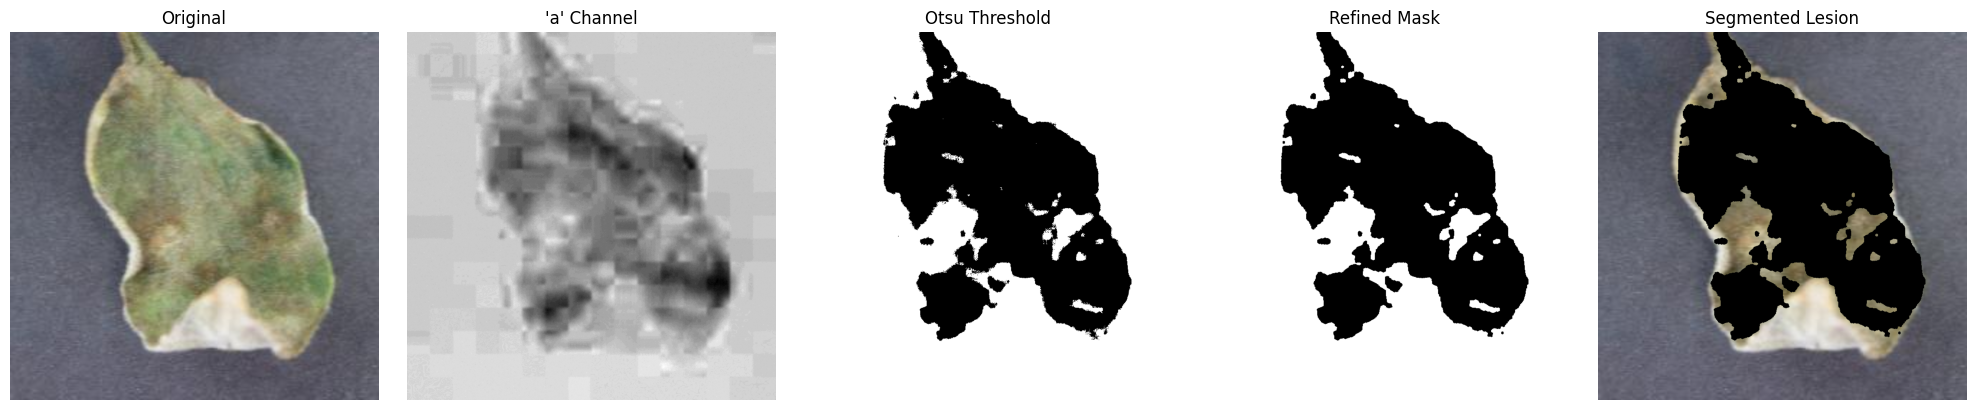


Found 1702 images for Tomato___Bacterial_spot
Found 800 images for Tomato___Early_blight
Found 1527 images for Tomato___Late_blight

Starting feature extraction for 4029 images...
Extraction complete. Valid samples: 4029

Tuning Random Forest...
Best RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Accuracy: 91.69%

Training SVM Benchmark...
SVM Accuracy: 90.82%

--- Final Comparison ---
Best Performing Model: Random Forest

Confusion Matrix (Random Forest):


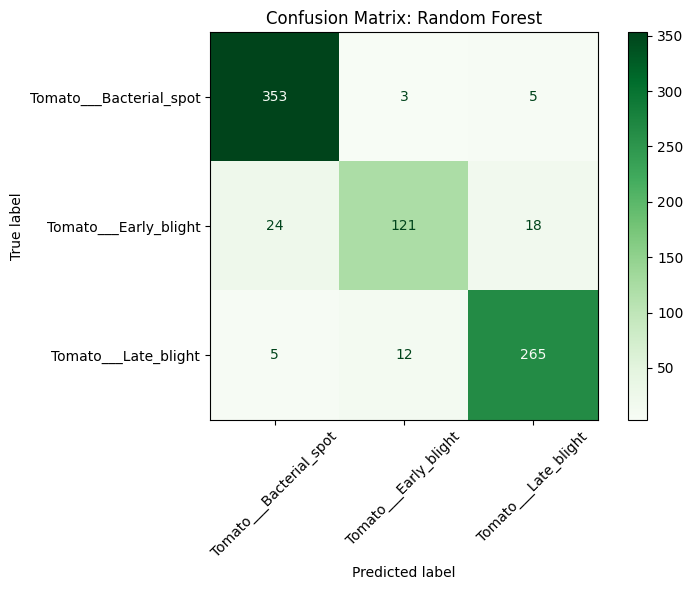

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/dataset/plantvillage"
labels = ["Tomato___Bacterial_spot", "Tomato___Early_blight", "Tomato___Late_blight"]

# --- 0. Visualize Segmentation on Samples (Added Step) ---
print("Selecting and visualizing samples from each class...")
sample_paths = []
for label in labels:
    folder_path = os.path.join(dataset_path, label)
    # Match common image extensions (case-insensitive)
    image_files = glob.glob(os.path.join(folder_path, "*.[jJ][pP][gG]")) + \
                  glob.glob(os.path.join(folder_path, "*.[jJ][pP][eE][gG]"))
    if image_files:
        sample_paths.append(image_files[0])

if sample_paths:
    visualize_segmentation_steps(sample_paths)

# Helper function for parallel processing
def process_single_image(file_path, label):
    try:
        img, mask = get_disease_mask(file_path)
        if img is not None:
            # Use the consolidated extract_features function defined previously
            feats = extract_features(img, mask)
            if np.sum(feats) > 0:
                return feats, label
    except Exception:
        pass
    return None

# --- 1. Data Collection ---
print("\nCollecting all image paths...")
all_tasks = []
for label in labels:
    folder_path = os.path.join(dataset_path, label)
    # Match common image extensions (case-insensitive)
    image_files = glob.glob(os.path.join(folder_path, "*.[jJ][pP][gG]")) + \
                  glob.glob(os.path.join(folder_path, "*.[jJ][pP][eE][gG]"))
    print(f"Found {len(image_files)} images for {label}")
    for file in image_files:
        all_tasks.append((file, label))

# --- 2. Parallel Feature Extraction ---
# Set verbose=0 to avoid stderr logs being interpreted as errors
print(f"\nStarting feature extraction for {len(all_tasks)} images...")
results = Parallel(n_jobs=-1, verbose=0)(
    delayed(process_single_image)(f, l) for f, l in all_tasks
)

# Filter valid results
data = []
target = []
for res in results:
    if res is not None:
        data.append(res[0])
        target.append(res[1])

if len(data) == 0:
    print("No features extracted. Please check dataset path and image integrity.")
else:
    X = np.array(data)
    y = np.array(target)
    print(f"Extraction complete. Valid samples: {len(X)}")

    # --- 3. Data Splitting & Scaling ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- 4. Random Forest with GridSearchCV ---
    print("\nTuning Random Forest...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_rf = grid_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test_scaled)
    acc_rf = accuracy_score(y_test, y_pred_rf)

    print(f"Best RF Params: {grid_search.best_params_}")
    print(f"Random Forest Accuracy: {acc_rf*100:.2f}%")

    # --- 5. SVM Benchmark ---
    print("\nTraining SVM Benchmark...")
    svm = SVC(kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train_scaled, y_train)
    y_pred_svm = svm.predict(X_test_scaled)
    acc_svm = accuracy_score(y_test, y_pred_svm)
    print(f"SVM Accuracy: {acc_svm*100:.2f}%")

    # --- 6. Comparison & Visualization ---
    print("\n--- Final Comparison ---")
    if acc_rf > acc_svm:
        best_model = best_rf
        y_pred_best = y_pred_rf
        best_name = "Random Forest"
    else:
        best_model = svm
        y_pred_best = y_pred_svm
        best_name = "SVM"

    print(f"Best Performing Model: {best_name}")

    print(f"\nConfusion Matrix ({best_name}):")
    cm = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Greens, ax=ax, xticks_rotation=45)
    plt.title(f"Confusion Matrix: {best_name}")
    plt.tight_layout()
    plt.show()